In [129]:
# Set working directory (optional during development)
import os
os.chdir('/Users/sudishmakarki/My_project2')  # only if needed
print(" Working directory:", os.getcwd())

# Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from prophet.diagnostics import cross_validation, performance_metrics




# Custom Functions
from models.data_interpolation import (
    load_data,
    preprocess_data,
    split_train_test,
    generate_time_series_splits
)

from models.model_prophet import (
    prepare_prophet_data,
    train_baseline_prophet,
    forecast_with_model,
    calculate_peak_hours,
    evaluate_metrics,
    cross_validate_baseline
)



 Working directory: /Users/sudishmakarki/My_project2


In [130]:
# Load and preprocess
df = load_data('data/RestaurantData.csv')
df_clean = preprocess_data(df)

                     Year  Month  Season  DayOfWeek WeekDay  Hour  \
Timestamp                                                           
2018-01-01 00:00:00  2018      1  Winter          1  Monday     0   
2018-01-01 01:00:00  2018      1  Winter          1  Monday     1   
2018-01-01 02:00:00  2018      1  Winter          1  Monday     2   
2018-01-01 03:00:00  2018      1  Winter          1  Monday     3   
2018-01-01 04:00:00  2018      1  Winter          1  Monday     4   

                            Holiday Weather SpecialEvent  CustomerCount  \
Timestamp                                                                 
2018-01-01 00:00:00  New Year's Day   Rainy          NaN              6   
2018-01-01 01:00:00  New Year's Day   Windy          NaN             11   
2018-01-01 02:00:00  New Year's Day   Snowy          NaN              9   
2018-01-01 03:00:00  New Year's Day   Rainy          NaN             10   
2018-01-01 04:00:00  New Year's Day  Cloudy          NaN          

In [131]:
# Split into train and test
restaurant_train, restaurant_test = split_train_test(df_clean, split_date='2022-01-01')
# Format for Prophet
restaurant_train_prophet, restaurant_test_prophet = prepare_prophet_data(restaurant_train, restaurant_test)
# Train the baseline Prophet model
m = train_baseline_prophet(restaurant_train_prophet)

In [132]:
# -- Test Set Forecasting --
# Predict on the test set and display the first few rows
test_forecast_df = forecast_with_model(m, restaurant_test_prophet)
print("Forecast on Test Set (first 5 rows):")
print(test_forecast_df.head())


Forecast on Test Set (first 5 rows):
                   ds      trend  yhat_lower  yhat_upper  trend_lower  \
0 2022-01-01 00:00:00  20.446485   -0.901301   18.342009    20.446485   
1 2022-01-01 01:00:00  20.446561    1.463894   20.380017    20.446561   
2 2022-01-01 02:00:00  20.446637    3.059396   21.618445    20.446637   
3 2022-01-01 03:00:00  20.446713    1.339585   19.982526    20.446713   
4 2022-01-01 04:00:00  20.446789   -0.921288   18.096420    20.446789   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    20.446485      -11.624321            -11.624321            -11.624321   
1    20.446561       -9.794884             -9.794884             -9.794884   
2    20.446637       -8.705095             -8.705095             -8.705095   
3    20.446713      -10.132657            -10.132657            -10.132657   
4    20.446789      -11.764320            -11.764320            -11.764320   

       daily  daily_lower  daily_upper    weekly  weekl

In [133]:
# Calculate average forecast per hour
hourly_avg = test_forecast_df.groupby('Hour')['yhat'].mean()
print("\nAverage Forecast by Hour:")
display(hourly_avg)


Average Forecast by Hour:


Hour
0      7.246245
1      9.169158
2     10.371492
3      9.074454
4      7.590038
5      8.459568
6     11.104544
7     12.760900
8     12.392444
9     12.769541
10    17.787457
11    27.462583
12    36.149942
13    36.782499
14    27.776974
15    15.894710
16    11.539598
17    20.027610
18    36.537792
19    49.516678
20    49.785918
21    37.493399
22    21.121063
23     9.987529
Name: yhat, dtype: float64

In [134]:
peak_hours_dynamic, hourly_avg, threshold = calculate_peak_hours(test_forecast_df)

print("\nThreshold for Peak Hours:", threshold)
print("\nDynamically Identified Peak Hours:", peak_hours_dynamic)

# Filter forecast and actuals for dynamically identified peak hours
forecast_peak_df = test_forecast_df[test_forecast_df['Hour'].isin(peak_hours_dynamic)]
actual_peak_df = restaurant_test_prophet[restaurant_test_prophet['Hour'].isin(peak_hours_dynamic)]


Threshold for Peak Hours: 29.87155088616458

Dynamically Identified Peak Hours: [12, 13, 18, 19, 20, 21]


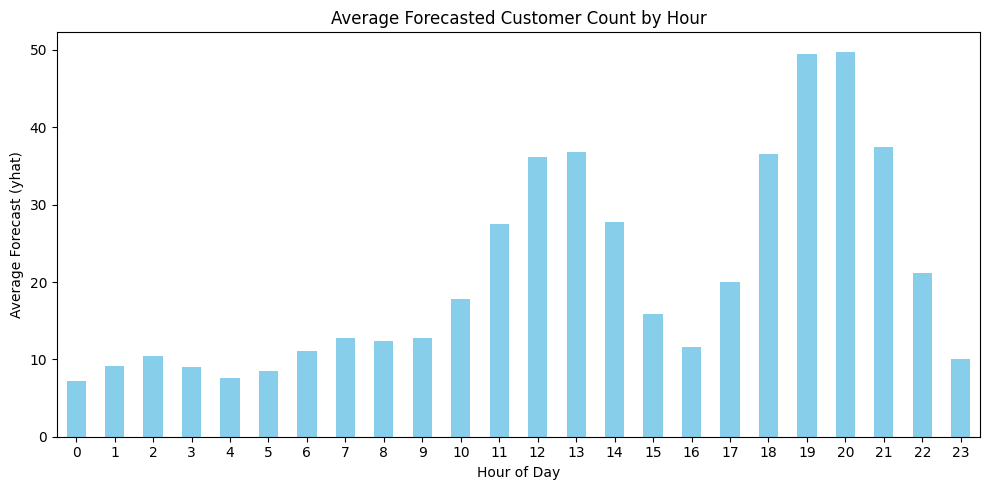

In [135]:
# ----- Average forecasted customer count by hour -----
plt.figure(figsize=(10, 5))
hourly_avg.plot(kind='bar', color='skyblue')
plt.title("Average Forecasted Customer Count by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Forecast (yhat)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

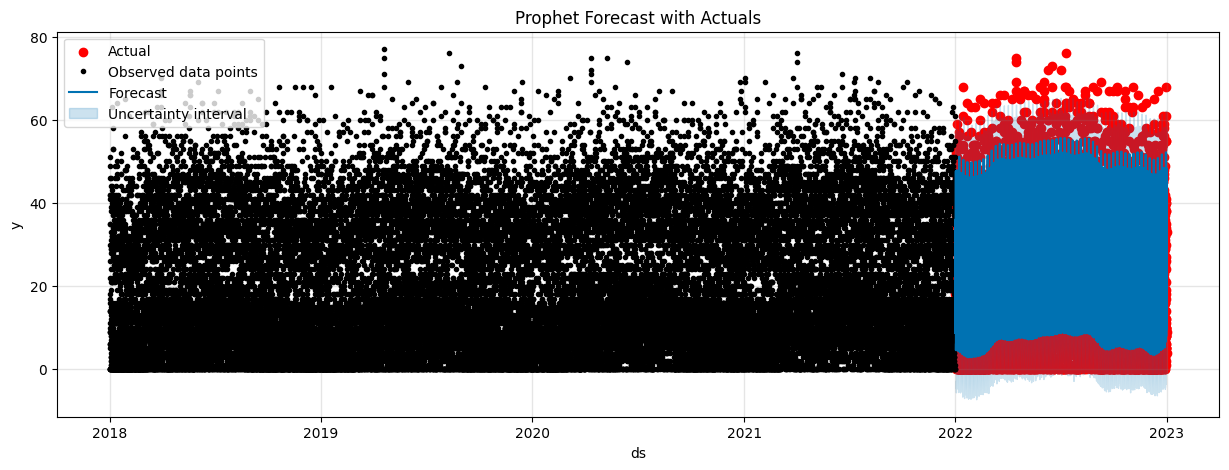

In [136]:
# ----- Compare Forecast to Actuals (All Hours) -----
# Plot the forecast with the actual test values
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(restaurant_test.index, restaurant_test['CustomerCount'], color='r', label='Actual')
fig = m.plot(test_forecast_df, ax=ax)
ax.set_title("Prophet Forecast with Actuals")
ax.legend()
plt.show()

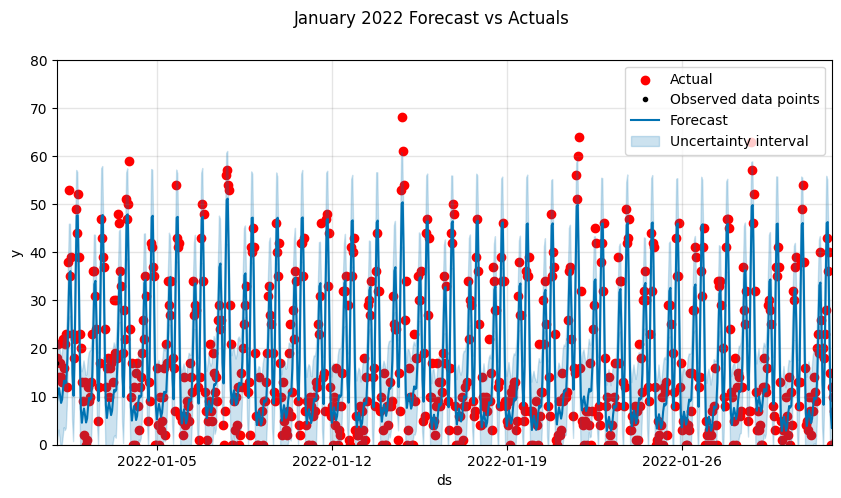

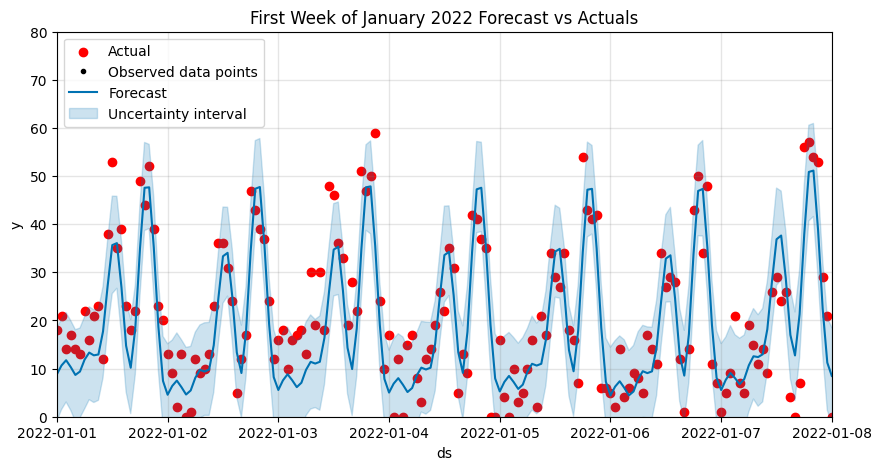

In [137]:
# ----- Zoom In: January 2022 (All Hours) -----
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(restaurant_test.index, restaurant_test['CustomerCount'], color='r', label='Actual')
fig = m.plot(test_forecast_df, ax=ax)
ax.set_xbound(lower=pd.to_datetime('2022-01-01'), upper=pd.to_datetime('2022-02-01'))
ax.set_ylim(0, 80)
plt.suptitle('January 2022 Forecast vs Actuals')
ax.legend()
plt.show()

# ----- Zoom In Further: First Week of January 2022 (All Hours) -----
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(restaurant_test.index, restaurant_test['CustomerCount'], color='r', label='Actual')
fig = m.plot(test_forecast_df, ax=ax)
lower_bound = pd.to_datetime('2022-01-01')
upper_bound = pd.to_datetime('2022-01-08')
ax.set_xbound(lower=lower_bound, upper=upper_bound)
ax.set_ylim(0, 80)
ax.set_title('First Week of January 2022 Forecast vs Actuals')
ax.legend()
plt.show()

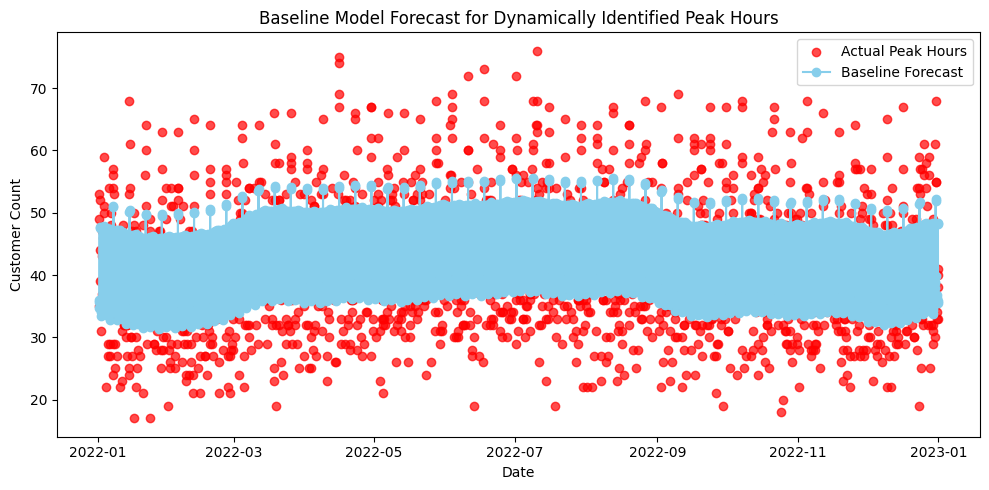

In [138]:
# ----- Compare Forecast vs. Actuals for Dynamically Identified Peak Hours -----
plt.figure(figsize=(10, 5))
plt.scatter(actual_peak_df['ds'], actual_peak_df['y'], 
            color='r', label='Actual Peak Hours', alpha=0.7)

plt.plot(forecast_peak_df['ds'], forecast_peak_df['yhat'], 
         marker='o', linestyle='-', color='skyblue', label='Baseline Forecast')

plt.xlabel('Date')
plt.ylabel('Customer Count')
plt.title('Baseline Model Forecast for Dynamically Identified Peak Hours')
plt.legend()
plt.tight_layout()
plt.show()

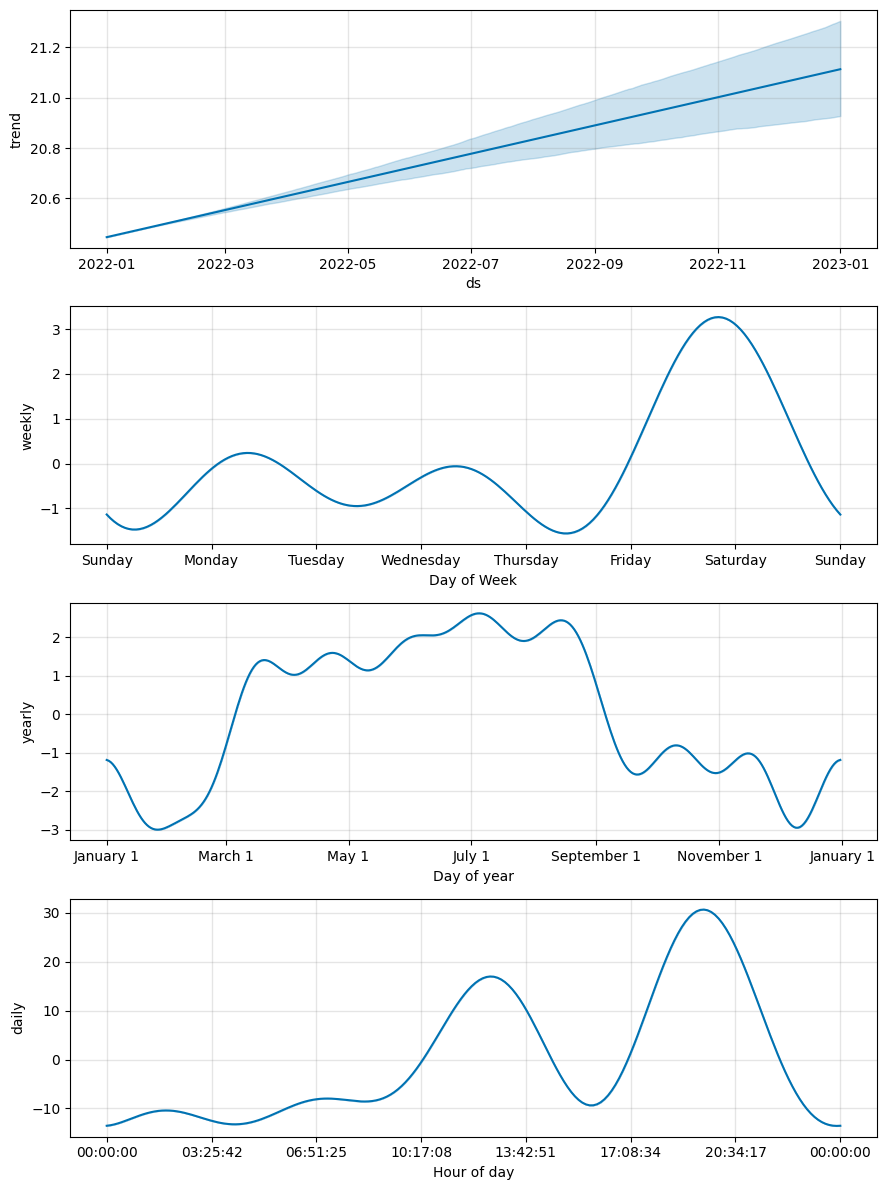

In [139]:
# ----- Plot Prophet Components for the Test Forecast -----
fig = m.plot_components(test_forecast_df)
plt.show()

Future Forecast:
                   ds      trend  yhat_lower  yhat_upper  trend_lower  \
0 2018-01-01 00:00:00  16.782304   -7.725381   11.830956    16.782304   
1 2018-01-01 01:00:00  16.782411   -5.973740   14.040708    16.782411   
2 2018-01-01 02:00:00  16.782518   -3.887737   15.124930    16.782518   
3 2018-01-01 03:00:00  16.782625   -5.723671   12.789306    16.782625   
4 2018-01-01 04:00:00  16.782732   -7.271627   11.904217    16.782732   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    16.782304      -14.846169            -14.846169            -14.846169   
1    16.782411      -12.845962            -12.845962            -12.845962   
2    16.782518      -11.574556            -11.574556            -11.574556   
3    16.782625      -12.811536            -12.811536            -12.811536   
4    16.782732      -14.245559            -14.245559            -14.245559   

       daily  daily_lower  daily_upper    weekly  weekly_lower  weekly_uppe

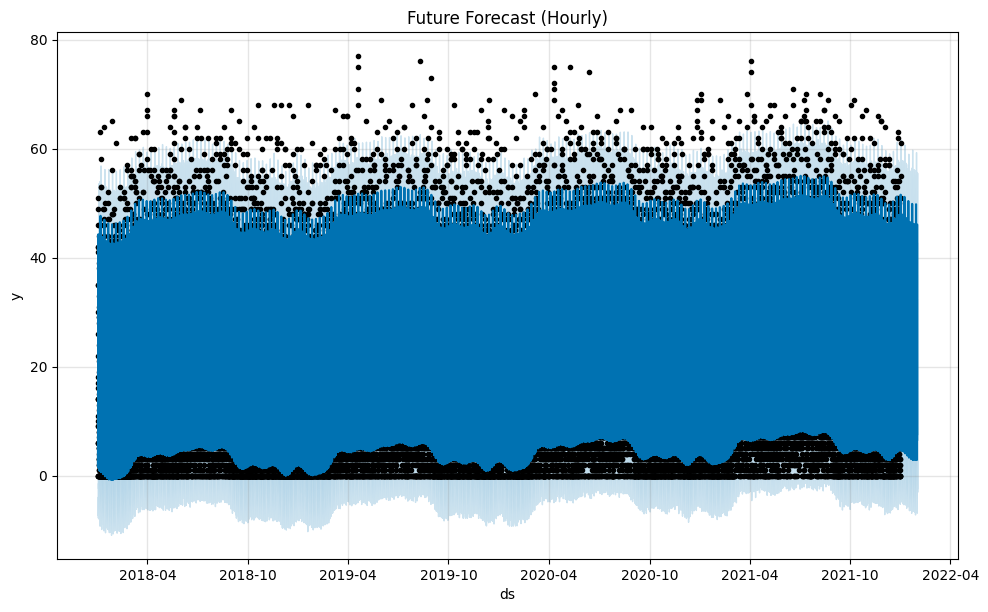


Future Average Forecast by Hour:
Hour
0      5.030926
1      6.954072
2      8.156692
3      6.859991
4      5.375956
5      6.245909
6      8.891347
7     10.548197
8     10.180264
9     10.557907
10    15.576386
11    25.252087
12    33.940030
13    34.573171
14    25.568225
15    13.686532
16     9.331976
17    17.820524
18    34.331219
19    47.310589
20    47.580281
21    35.288178
22    18.916220
23     7.783022
Name: yhat, dtype: float64

Threshold for Peak Hours: 28.548168889830286

Dynamically Selected Peak Hours: [12, 13, 18, 19, 20, 21]


In [140]:
# -- Future Forecasting (baseline) --
# Generate future data for the next 30 days at hourly frequency
future = m.make_future_dataframe(periods=30*24, freq='h')
forecast_future = m.predict(future)

print("Future Forecast:")
print(forecast_future.head())

# Plot the future forecast (historical data in black, forecast in blue)
m.plot(forecast_future)
plt.title("Future Forecast (Hourly)")
plt.show()

# Calculate the average forecast (yhat) per hour from the future forecast
forecast_future['Hour'] = forecast_future['ds'].dt.hour
future_hourly_avg = forecast_future.groupby('Hour')['yhat'].mean()
print("\nFuture Average Forecast by Hour:")
print(future_hourly_avg)

# Define a threshold based on the maximum forecast value (e.g., 60% of max)
threshold = 0.6 * future_hourly_avg.max()
print("\nThreshold for Peak Hours:", threshold)

# Dynamically select all hours where the forecast meets or exceeds the threshold
future_peak_hours = sorted([hour for hour, demand in future_hourly_avg.items() if demand >= threshold])
print("\nDynamically Selected Peak Hours:", future_peak_hours)

In [141]:
# ----- Evaluate Error Metrics for All Test Data -----
mae_all = mean_absolute_error(
    y_true=restaurant_test['CustomerCount'],
    y_pred=test_forecast_df['yhat']
)
rmse_all = np.sqrt(mean_squared_error(
    y_true=restaurant_test['CustomerCount'],
    y_pred=test_forecast_df['yhat']
))
mape_all = mean_absolute_percentage_error(
    y_true=restaurant_test['CustomerCount'],
    y_pred=test_forecast_df['yhat']
)

print("Overall Test Data Metrics:")
print("MAE:", mae_all)
print("RMSE:", rmse_all)
print("MAPE:", mape_all)

Overall Test Data Metrics:
MAE: 6.178832523928045
RMSE: 7.792611337402785
MAPE: 1750259904361487.0


In [142]:
# ----- Evaluate Error Metrics for Peak Hours -----
# Align the forecasts and actual values by their datetime 'ds' for peak hours
actual_peak = actual_peak_df.set_index('ds')['y']
predicted_peak = forecast_peak_df.set_index('ds')['yhat']

mae_peak = mean_absolute_error(actual_peak, predicted_peak)
rmse_peak = np.sqrt(mean_squared_error(actual_peak, predicted_peak))
mape_peak = mean_absolute_percentage_error(actual_peak, predicted_peak)

print("\nPeak Hours Metrics:")
print("Baseline Peak Hours MAE:", mae_peak)
print("Baseline Peak Hours RMSE:", rmse_peak)
print("Baseline Peak Hours MAPE:", mape_peak)


Peak Hours Metrics:
Baseline Peak Hours MAE: 7.438054978068848
Baseline Peak Hours RMSE: 9.273396642585928
Baseline Peak Hours MAPE: 0.1853811961525984


In [143]:
# Use your baseline model (m) for cross-validation.
df_cv_baseline = cross_validation(m, initial='730 days', period='180 days', horizon='365 days')
df_p_baseline = performance_metrics(df_cv_baseline)

print("Cross-Validation Performance Metrics for Baseline Model:")
print(df_p_baseline.head())

  0%|          | 0/3 [00:00<?, ?it/s]

Cross-Validation Performance Metrics for Baseline Model:
           horizon        mse      rmse       mae     mdape     smape  \
0 36 days 12:00:00  51.469030  7.174192  5.640334  0.316656  0.537412   
1 36 days 13:00:00  51.363676  7.166846  5.633327  0.316138  0.536468   
2 36 days 14:00:00  51.326250  7.164234  5.630596  0.315422  0.535417   
3 36 days 15:00:00  51.385046  7.168336  5.631366  0.314798  0.534419   
4 36 days 16:00:00  51.372589  7.167467  5.629546  0.314319  0.533671   

   coverage  
0  0.817732  
1  0.818113  
2  0.818113  
3  0.817732  
4  0.817732  
